## Выделить независимые и зависимые переменные
#### Независимые:
- Freq – частота стимуляции
- Onset – задержка стимуляции
- StimSite – регион стимуляции
- Stimulus - стимул
- Lobule – доля головного мозга

#### Зависимые:
- Response - ответ
- Error type – тип ошибки
- Pain – наличие болевых ощущений _(может зависеть от частоты)_
- RT_start – скорость реакции (начало произнесения целевого слова)
- RT_end - скорость реакции (окончание произнесения целевого слова)
- Error – наличие ошибки (1 – есть ошибка, 0 – нет ошибки)


#### Побочные:
- pID – идентификатор участника
- 110% MT – 110% от моторного порога
- MT – моторный порог

## Какие переменные межгрупповые, какие внутригрупповые?


Судя по таблице:
- межгрупповой: Onset – задержка стимуляции
- внутригрупповой: Freq – частота стимуляции

Судя по тексту: "Признак частоты – внутригрупповой, начало стимуляции – межгрупповой"(С)



## Провести дескриптивный анализ:
#### поделить данные на выборки;

In [2]:
import numpy as np
import pandas as pd

import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

import scipy
from scipy import stats
from scipy.stats import kruskal, chi2, f_oneway

import matplotlib.pyplot as plt
import seaborn as sns

import pathlib

In [3]:
DATADIR = pathlib.Path.cwd() / "data"
RANDOM_STATE = 42

In [4]:
df_data = pd.read_excel(DATADIR / "data_TMS.xlsx")
df_data.head()

,pID,Freq,Onset,Session,110% MT,MT,StimSite,Stimulus,Response,Error_type,Pain,RT_start,RT_end,Protocol_name,Error,lobule
0,2,5,0,day1,65,59,L_mSFG_3,мотоцикл,Это мотоцикл,NaN,0,576.0,1003.0,5.0 Hz 0.0 ms,0,frontal
1,2,5,0,day1,65,59,L_mSFG_2,вешалка,Это вешалка,NaN,0,521.0,932.0,5.0 Hz 0.0 ms,0,frontal
2,2,5,0,day1,65,59,L_mSFG_1,брюки,Это штаны,NaN,0,467.0,785.0,5.0 Hz 0.0 ms,0,frontal
3,2,5,0,day1,65,59,L_pSFG,рояль,Это рояль,NaN,0,509.0,861.0,5.0 Hz 0.0 ms,0,frontal
4,2,5,0,day1,65,59,L_pMFG_1,бинокль,Это бинокль,NaN,0,530.0,1087.0,5.0 Hz 0.0 ms,0,frontal


In [5]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12913 entries, 0 to 12912
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   pID            12913 non-null  int64  
 1   Freq           12913 non-null  int64  
 2   Onset          12913 non-null  int64  
 3   Session        12913 non-null  object 
 4   110% MT        12913 non-null  int64  
 5   MT             12913 non-null  int64  
 6   StimSite       12913 non-null  object 
 7   Stimulus       12913 non-null  object 
 8   Response       8438 non-null   object 
 9   Error_type     997 non-null    object 
 10  Pain           12913 non-null  int64  
 11  RT_start       12128 non-null  float64
 12  RT_end         12128 non-null  float64
 13  Protocol_name  12913 non-null  object 
 14  Error          12913 non-null  int64  
 15  lobule         12913 non-null  object 
dtypes: float64(2), int64(7), object(7)
memory usage: 1.6+ MB


In [6]:
df_data["Error_type"] = df_data["Error_type"].fillna("NoError")
df_data["Response"] = df_data["Response"].fillna("NoResponse")
df_data = df_data.dropna(subset=['RT_start', 'RT_start'])

In [7]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12128 entries, 0 to 12912
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   pID            12128 non-null  int64  
 1   Freq           12128 non-null  int64  
 2   Onset          12128 non-null  int64  
 3   Session        12128 non-null  object 
 4   110% MT        12128 non-null  int64  
 5   MT             12128 non-null  int64  
 6   StimSite       12128 non-null  object 
 7   Stimulus       12128 non-null  object 
 8   Response       12128 non-null  object 
 9   Error_type     12128 non-null  object 
 10  Pain           12128 non-null  int64  
 11  RT_start       12128 non-null  float64
 12  RT_end         12128 non-null  float64
 13  Protocol_name  12128 non-null  object 
 14  Error          12128 non-null  int64  
 15  lobule         12128 non-null  object 
dtypes: float64(2), int64(7), object(7)
memory usage: 1.6+ MB


In [8]:
df_data.nunique()

pID               44
Freq               2
Onset              2
Session            2
110% MT           32
MT                32
StimSite          46
Stimulus          78
Response         810
Error_type         9
Pain               1
RT_start         593
RT_end           785
Protocol_name      4
Error              2
lobule             3
dtype: int64

In [9]:
## Только одно значение Pain -> можно дропнуть
df_data = df_data.drop("Pain", axis=1)

In [10]:
## Комбинация "Freq" и "Onset" уже закодирована в Protocol_name -> можно дропнуть
df_data = df_data.drop(["Freq", "Onset"], axis=1)

In [11]:
## Стимулы и ответы нам тоже в целом не нужны
df_data = df_data.drop(["Stimulus", "Response"], axis=1)

In [12]:
df_data["Protocol_name"].unique()

array(['5.0 Hz 0.0 ms', '10.0 Hz 0.0 ms', '5.0 Hz 300.0 ms',
       '10.0 Hz 300.0 ms'], dtype=object)

In [13]:
## Проставим метки: является ли точка речевой
df_target = df_data.groupby(['pID', 'Protocol_name', 'StimSite'])['Error'].sum().reset_index()
df_target.head(10)

,pID,Protocol_name,StimSite,Error
0,2,10.0 Hz 0.0 ms,L_SPL_1,0
1,2,10.0 Hz 0.0 ms,L_SPL_2,1
2,2,10.0 Hz 0.0 ms,L_aSMG_1,0
3,2,10.0 Hz 0.0 ms,L_aSMG_2,1
4,2,10.0 Hz 0.0 ms,L_aSTG,1
5,2,10.0 Hz 0.0 ms,L_anG_1,0
6,2,10.0 Hz 0.0 ms,L_anG_2,1
7,2,10.0 Hz 0.0 ms,L_anG_4,2
8,2,10.0 Hz 0.0 ms,L_dPoG,0
9,2,10.0 Hz 0.0 ms,L_dPrG,2


In [14]:
df_target["isSpeechDependent"] = df_target["Error"].apply(lambda x: x > 1)
df_target.head(10)

,pID,Protocol_name,StimSite,Error,isSpeechDependent
0,2,10.0 Hz 0.0 ms,L_SPL_1,0,False
1,2,10.0 Hz 0.0 ms,L_SPL_2,1,False
2,2,10.0 Hz 0.0 ms,L_aSMG_1,0,False
3,2,10.0 Hz 0.0 ms,L_aSMG_2,1,False
4,2,10.0 Hz 0.0 ms,L_aSTG,1,False
5,2,10.0 Hz 0.0 ms,L_anG_1,0,False
6,2,10.0 Hz 0.0 ms,L_anG_2,1,False
7,2,10.0 Hz 0.0 ms,L_anG_4,2,True
8,2,10.0 Hz 0.0 ms,L_dPoG,0,False
9,2,10.0 Hz 0.0 ms,L_dPrG,2,True


In [15]:
# Для удобства перезапишем вот так

groups = {
    name[0]: group
    for name, group in df_data.groupby(['Protocol_name'])
}

In [16]:
df_data.columns

Index(['pID', 'Session', '110% MT', 'MT', 'StimSite', 'Error_type', 'RT_start',
       'RT_end', 'Protocol_name', 'Error', 'lobule'],
      dtype='object')

In [17]:
df_data.head()

,pID,Session,110% MT,MT,StimSite,Error_type,RT_start,RT_end,Protocol_name,Error,lobule
0,2,day1,65,59,L_mSFG_3,NoError,576.0,1003.0,5.0 Hz 0.0 ms,0,frontal
1,2,day1,65,59,L_mSFG_2,NoError,521.0,932.0,5.0 Hz 0.0 ms,0,frontal
2,2,day1,65,59,L_mSFG_1,NoError,467.0,785.0,5.0 Hz 0.0 ms,0,frontal
3,2,day1,65,59,L_pSFG,NoError,509.0,861.0,5.0 Hz 0.0 ms,0,frontal
4,2,day1,65,59,L_pMFG_1,NoError,530.0,1087.0,5.0 Hz 0.0 ms,0,frontal


## построить графики распределений
не совсем понял, каких конкретно распределений. поэтому нарисую просто всякие.

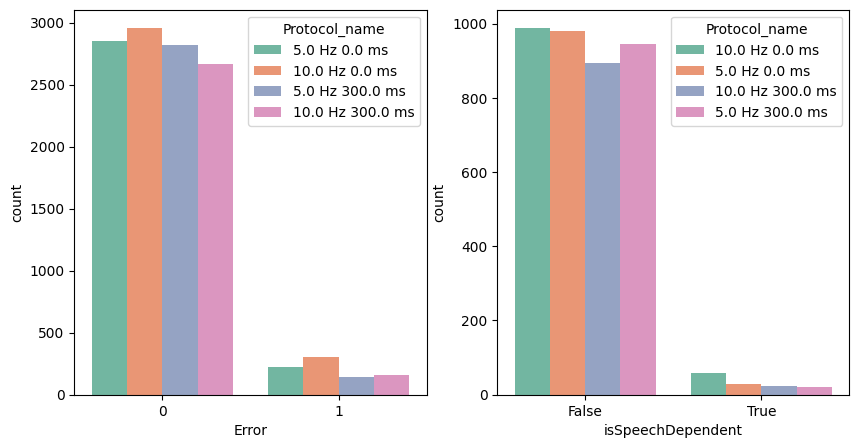

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2,  figsize = (10, 5))
sns.countplot(df_data,x='Error', hue='Protocol_name',palette="Set2", ax=axes[0])
sns.countplot(df_target,x='isSpeechDependent', hue='Protocol_name',palette="Set2", ax=axes[1])
plt.show()
## Будто бы 10.0 Hz 0.0 ms выглядит круче всего. Однако нужно будет проверить стат тестом (далее)

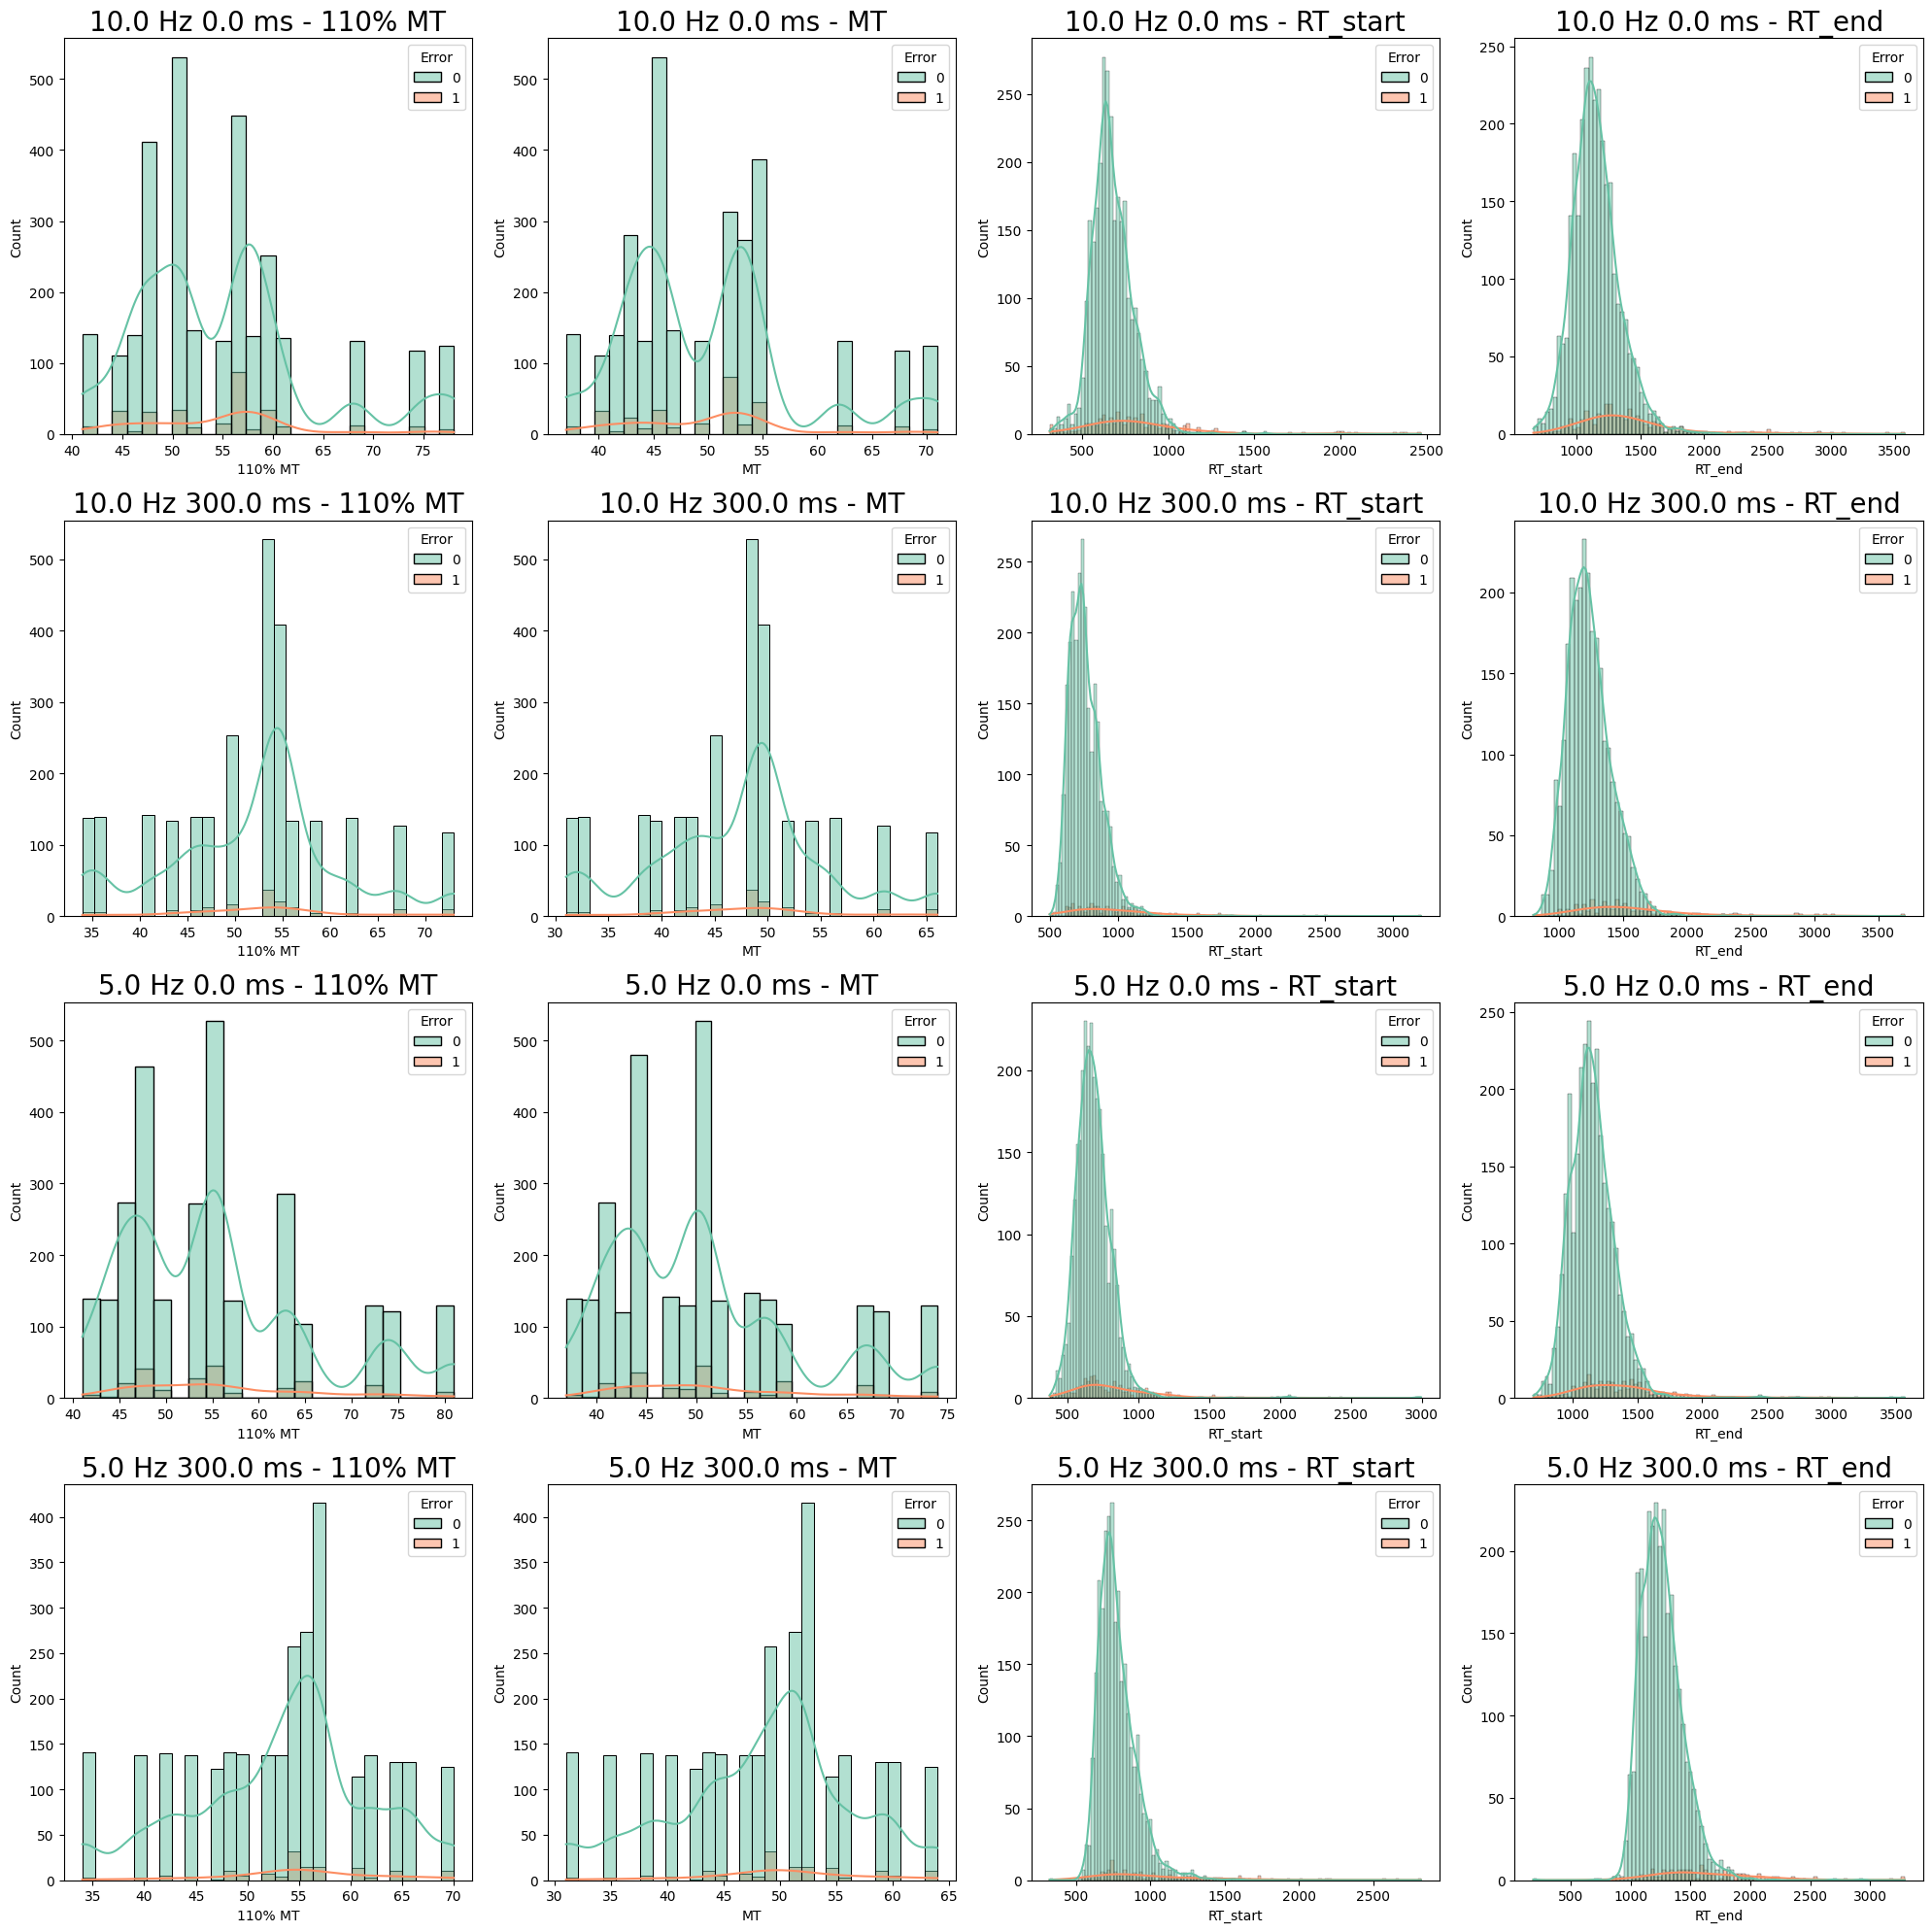

In [19]:
fig, axes = plt.subplots(nrows= 4, ncols=4, figsize=(20, 20))


for i, (name, group) in enumerate(groups.items()):
    for j, feature in enumerate(["110% MT", "MT", "RT_start", "RT_end",]):
        sns.histplot(group, x=feature, ax=axes[i, j], kde=True, hue="Error",palette="Set2")
        axes[i, j].set_title(f"{name} - {feature}", fontsize=20)

plt.tight_layout()
plt.show()

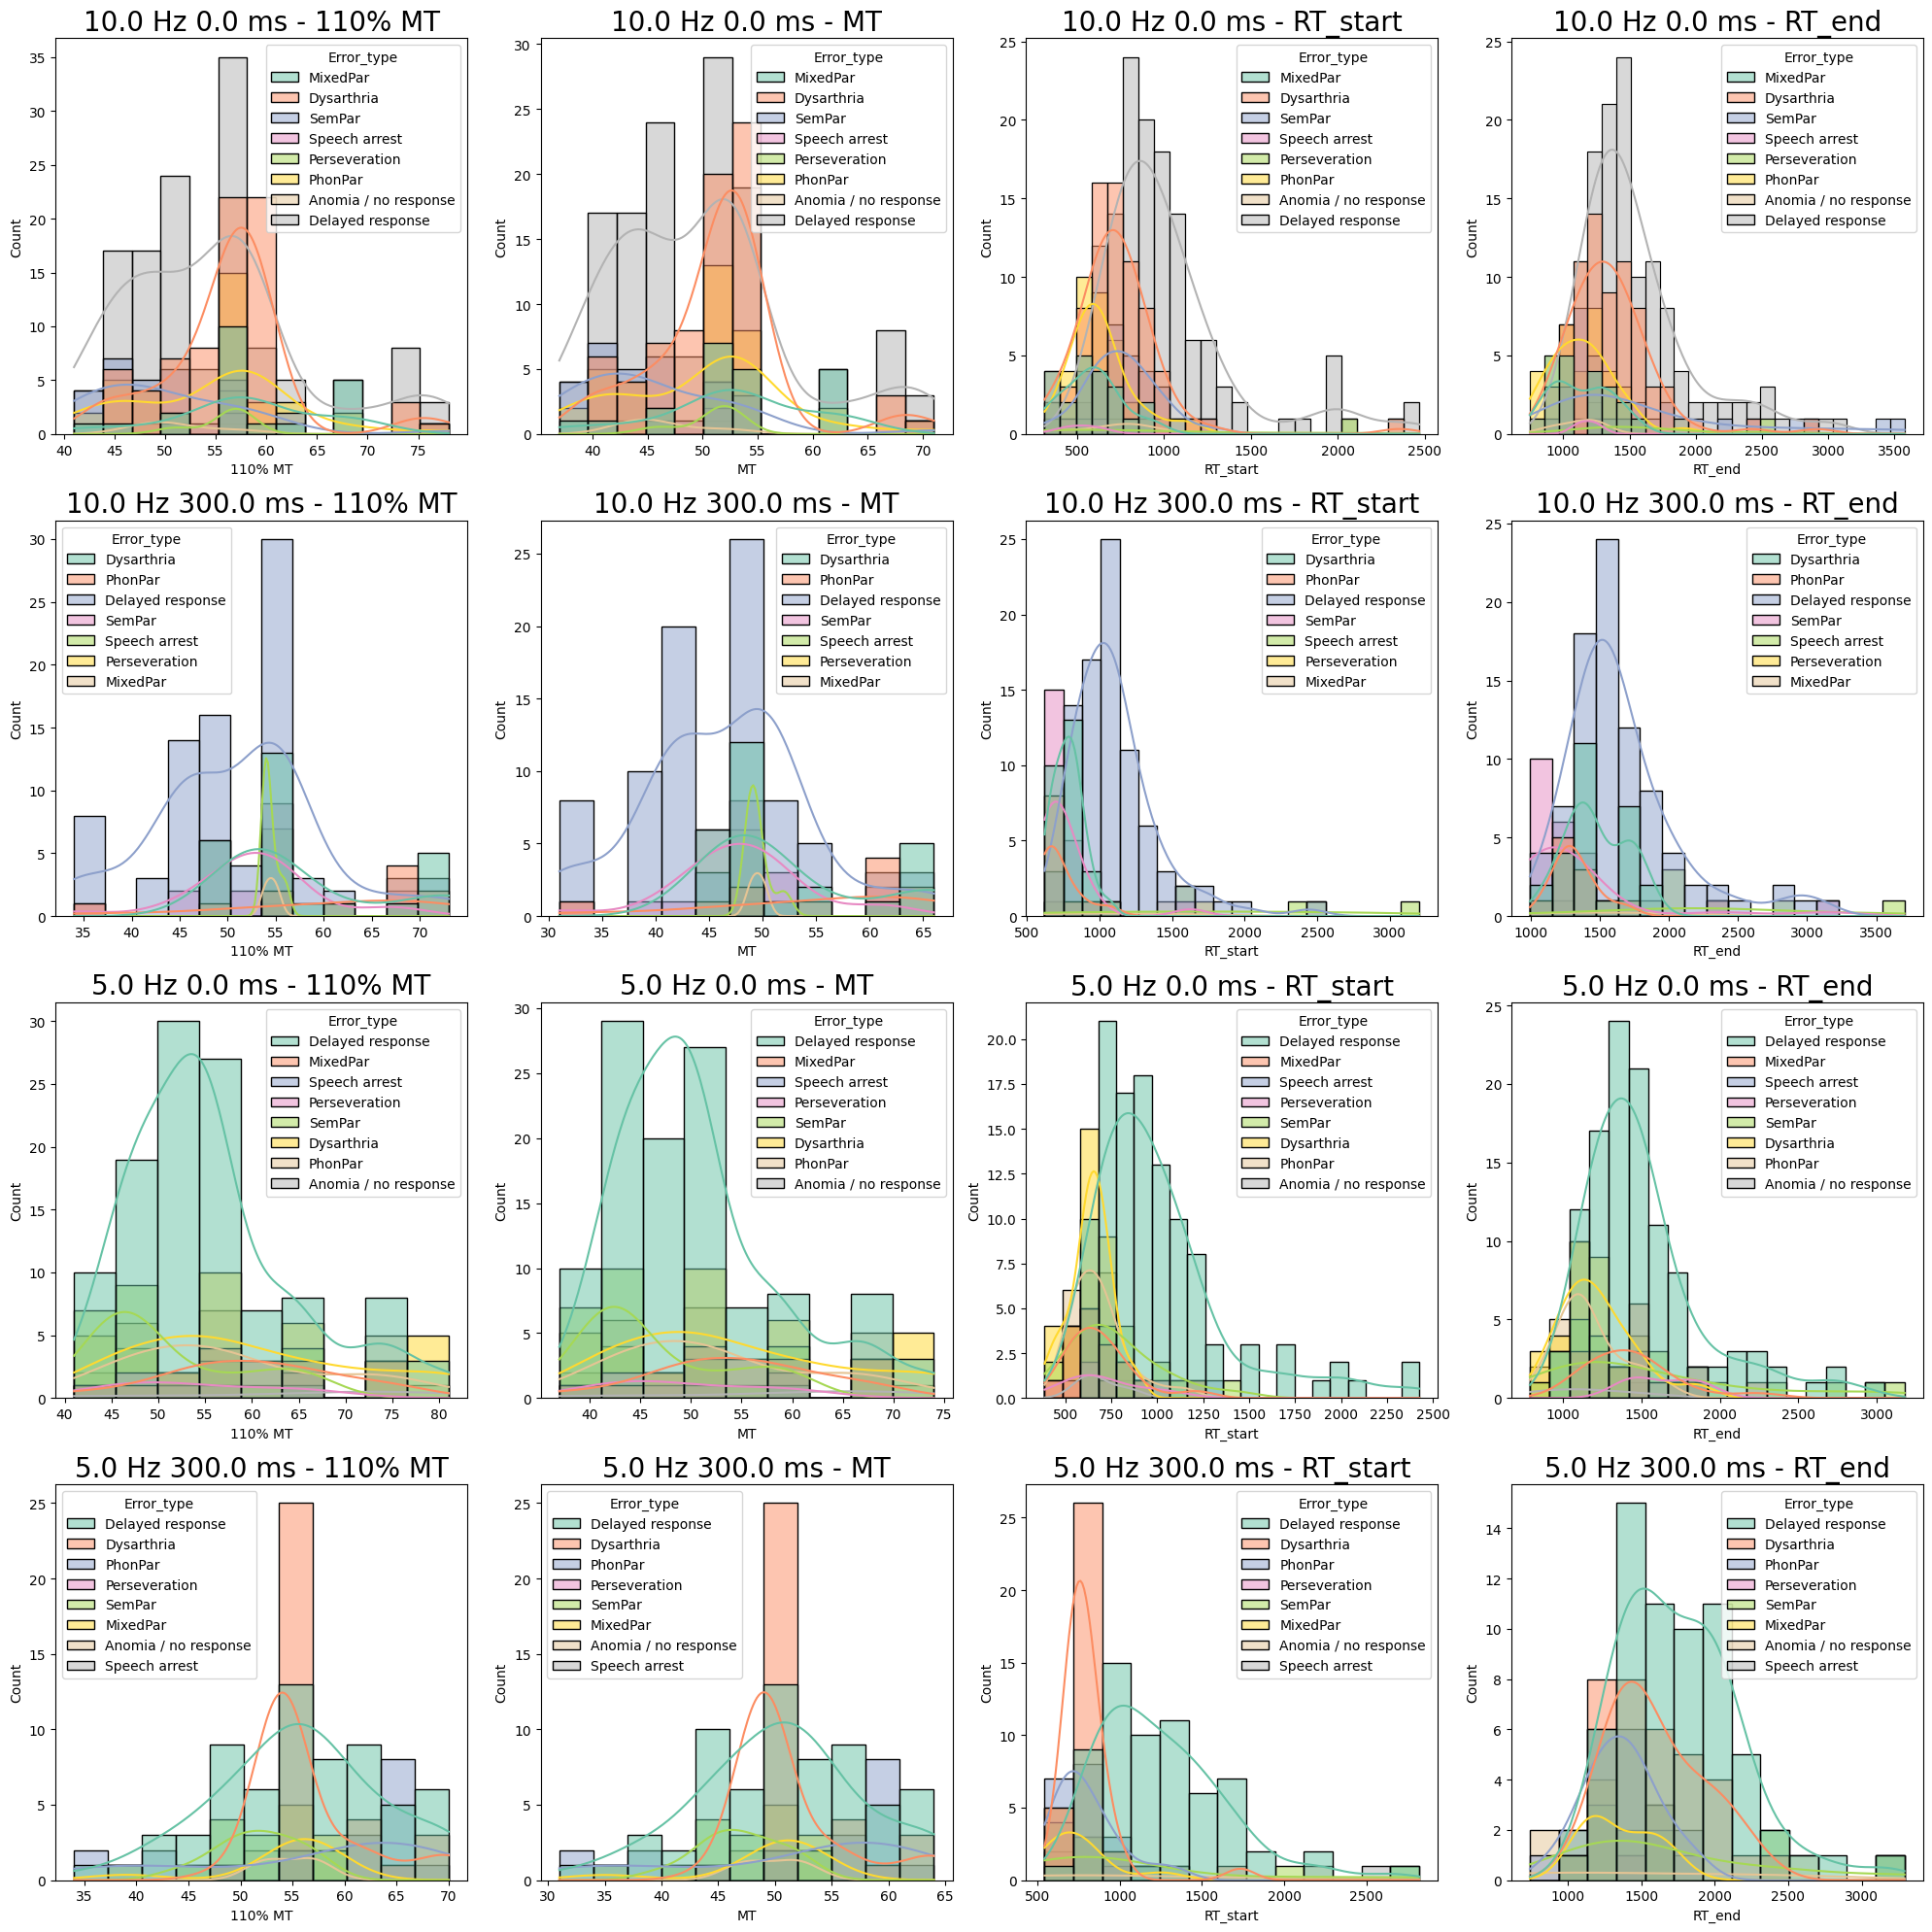

In [20]:
fig, axes = plt.subplots(nrows= 4, ncols=4, figsize=(20, 20))


for i, (name, group) in enumerate(groups.items()):
    for j, feature in enumerate(["110% MT", "MT", "RT_start", "RT_end",]):
        filter_group = group[group["Error_type"] != "NoError"]
        sns.histplot(filter_group, x=feature, ax=axes[i, j], kde=True, hue="Error_type",palette="Set2")
        axes[i, j].set_title(f"{name} - {feature}", fontsize=20)

plt.tight_layout()
plt.show()

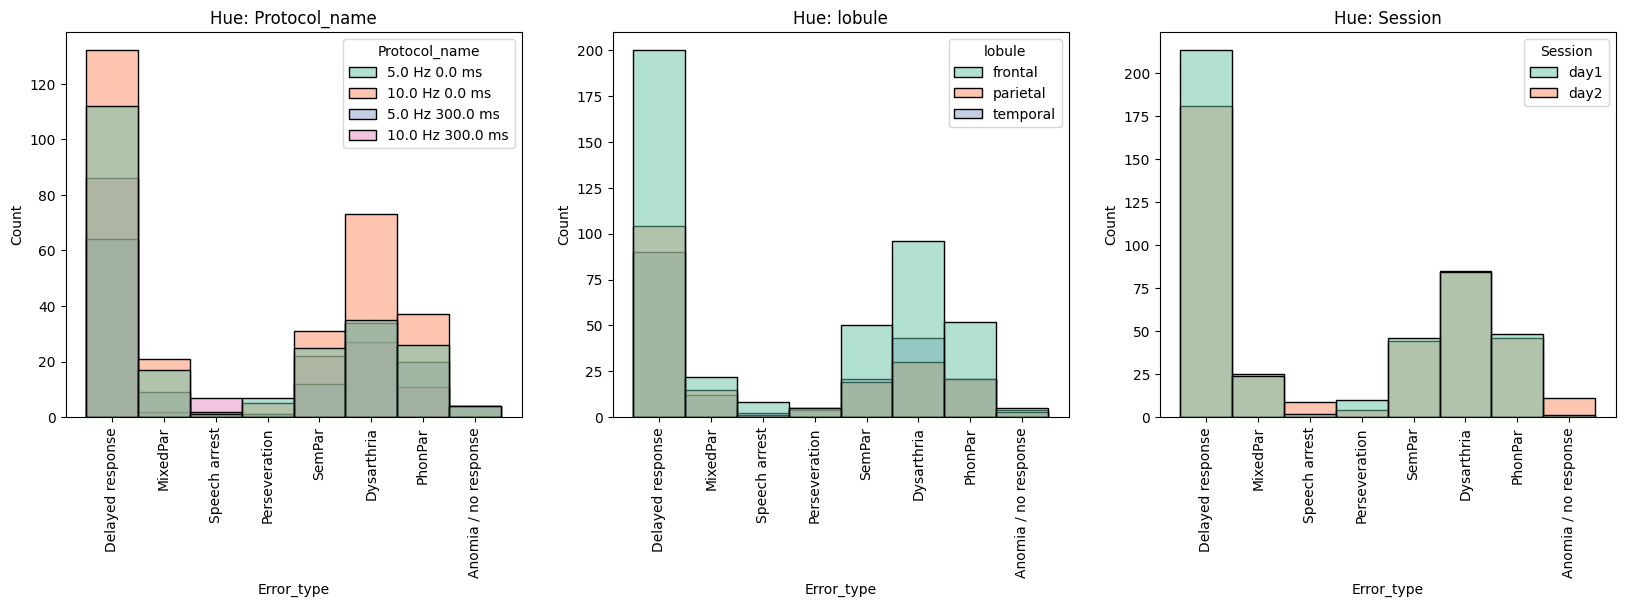

In [21]:
fig, axes = plt.subplots(nrows= 1, ncols=3, figsize=(20, 5))

for i, hue in enumerate(["Protocol_name", "lobule", "Session",]):

    sns.histplot(
        df_data[df_data["Error_type"] != "NoError"],
        x="Error_type",
        hue=hue,
        palette="Set2",
        ax=axes[i]
    )
    axes[i].tick_params(axis='x', rotation=90)
    axes[i].set_title(f"Hue: {hue}")

plt.show()

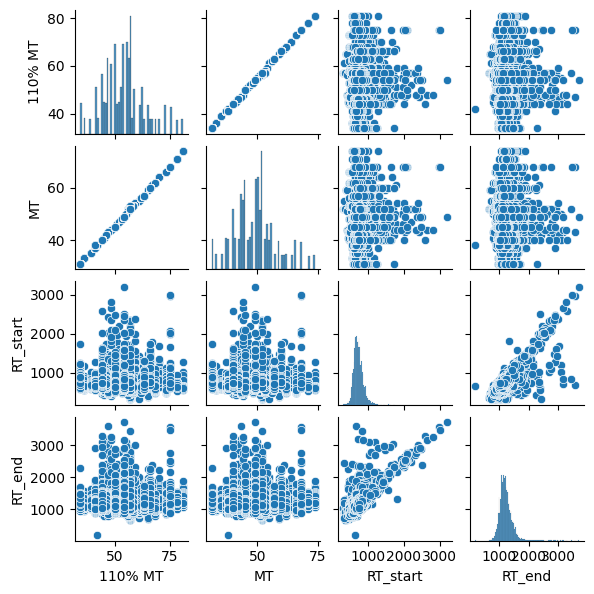

In [22]:
sns.pairplot(df_data[["110% MT", "MT", "RT_start", "RT_end",]], height=1.5 )

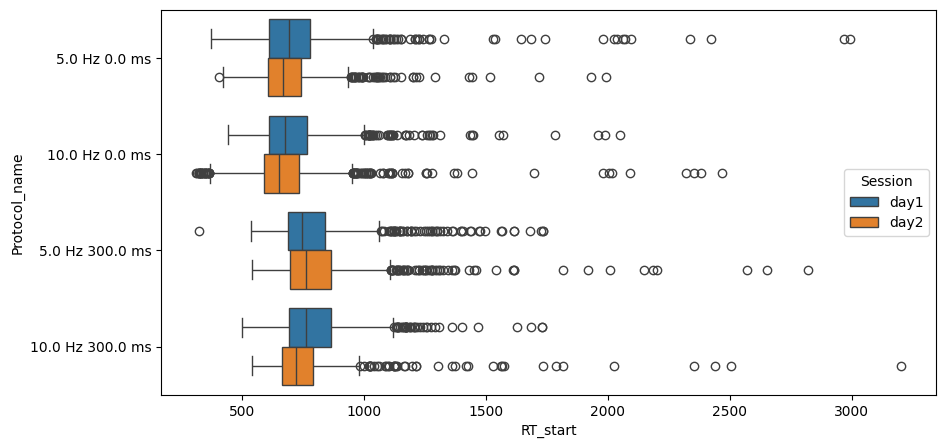

In [23]:
fig, ax = plt.subplots( figsize = (10, 5))
sns.boxplot(df_data,x='RT_start', y="Protocol_name", hue='Session',)
plt.show()

## рассчитать медиану, среднее, стандартное отклонение, максимальные и минимальные значения для всех данных и для каждой из выборок. 

In [24]:
# Медианы в дискрайбе нет поэтому добавим так

def my_describe(df: pd.DataFrame):
    describe = df.describe()
    describe.loc["median"] = df.median(numeric_only=True)
    return describe

In [25]:
my_describe(df_data)

,pID,110% MT,MT,RT_start,RT_end,Error
count,12128.000000,12128.000000,12128.000000,12128.000000,12128.000000,12128.000000
mean,26.598532,54.017398,49.122609,736.850181,1220.040485,0.068684
std,14.127382,9.380767,8.516916,169.732832,223.748942,0.252927
min,2.000000,34.000000,31.000000,312.000000,185.000000,0.000000
25%,14.000000,48.000000,44.000000,639.000000,1081.000000,0.000000
50%,26.000000,54.000000,49.000000,714.000000,1191.000000,0.000000
75%,39.000000,58.000000,53.000000,806.250000,1320.000000,0.000000
max,50.000000,81.000000,74.000000,3202.000000,3705.000000,1.000000
median,26.000000,54.000000,49.000000,714.000000,1191.000000,0.000000


In [26]:
for name, group in groups.items():
    print("--->", name, "<---")
    print(my_describe(group), end="\n\n")

---> 10.0 Hz 0.0 ms <---
                pID      110% MT           MT     RT_start       RT_end  \
count   3261.000000  3261.000000  3261.000000  3261.000000  3261.000000   
mean      26.296841    54.867832    49.933763   691.797608  1178.522539   
std       14.566609     8.853443     8.101990   164.529700   233.399423   
min        2.000000    41.000000    37.000000   312.000000   660.000000   
25%       15.000000    48.000000    44.000000   602.000000  1042.000000   
50%       26.000000    55.000000    50.000000   665.000000  1148.000000   
75%       39.000000    59.000000    54.000000   754.000000  1273.000000   
max       50.000000    78.000000    71.000000  2468.000000  3578.000000   
median    26.000000    55.000000    50.000000   665.000000  1148.000000   

              Error  
count   3261.000000  
mean       0.093530  
std        0.291218  
min        0.000000  
25%        0.000000  
50%        0.000000  
75%        0.000000  
max        1.000000  
median     0.000000  

---

## Построить две пары гипотез (каждая пара - основная и альтернативная) о закономерностях, наблюдаемых в данных

- H01: Эффективность обнаружения речевых точек не зависит от протокола стимуляции.
- H11: Эффективность обнаружения речевых точек зависит от протокола стимуляции.

<s>
- H02: Cкорость реакции (начало произнесения целевого слова) не зависит от протокола стимуляции.
- H12: Cкорость реакции (начало произнесения целевого слова) зависит от протокола стимуляции.
</s>  Эти гипотезы не подходят для корреляционного анализа тк одна из переменных категориальная.

- H02: Конец произнесения целевого слова не зависит от начала произнесения целевого слова.
- H12: Конец произнесения целевого слова зависит от начала произнесения целевого слова.

## Проверить первую гипотезу с помощью статистического критерия об однородности выборок (Критерий t-Стьюдента/Критерий Вилкоксона/Дисперсионный анализ ANOVA

In [27]:
#  Нам нужно будет проверять выборки на нормальность
def show_groups_normal(grouped_df, subset):
    for name, group in grouped_df:
        stat, p_value = stats.shapiro(group[subset])
        print(name)
        print(f"{stat}: p-value = {p_value:.4f}", end="\n\n")

In [28]:
df_target.head(10)

,pID,Protocol_name,StimSite,Error,isSpeechDependent
0,2,10.0 Hz 0.0 ms,L_SPL_1,0,False
1,2,10.0 Hz 0.0 ms,L_SPL_2,1,False
2,2,10.0 Hz 0.0 ms,L_aSMG_1,0,False
3,2,10.0 Hz 0.0 ms,L_aSMG_2,1,False
4,2,10.0 Hz 0.0 ms,L_aSTG,1,False
5,2,10.0 Hz 0.0 ms,L_anG_1,0,False
6,2,10.0 Hz 0.0 ms,L_anG_2,1,False
7,2,10.0 Hz 0.0 ms,L_anG_4,2,True
8,2,10.0 Hz 0.0 ms,L_dPoG,0,False
9,2,10.0 Hz 0.0 ms,L_dPrG,2,True


In [29]:
##  Данные распределены ненормально
show_groups_normal(df_target.groupby("Protocol_name"), "isSpeechDependent")

10.0 Hz 0.0 ms
0.2392250871606998: p-value = 0.0000

10.0 Hz 300.0 ms
0.14033393936593985: p-value = 0.0000

5.0 Hz 0.0 ms
0.15430427983654338: p-value = 0.0000

5.0 Hz 300.0 ms
0.1270438011221785: p-value = 0.0000



In [30]:
## тк распределение ненормальное, используем непараметрический аналог ANOVA критерий Краскела-Уоллиса
kruskal(*[group["isSpeechDependent"] for name, group in df_target.groupby("Protocol_name")])
## p-value сильно меньше 0.05 дает основания заключить,
## что есть статистически значимая разница между различными протоколами стимуляции
## далее можно провести парные тесты, либо прикинуть по барплоту, что 10 Hz 0 Ms лучше,
## но по заданию этого делать не нужно

KruskalResult(statistic=np.float64(22.5531200498738), pvalue=np.float64(5.003907717498423e-05))

## Проверить вторую гипотезу с помощью теста корреляции (Пирсона/Спирмена), построить матрицу сопряженности для величин, прокомментировать результат

In [31]:
df_data.head()

,pID,Session,110% MT,MT,StimSite,Error_type,RT_start,RT_end,Protocol_name,Error,lobule
0,2,day1,65,59,L_mSFG_3,NoError,576.0,1003.0,5.0 Hz 0.0 ms,0,frontal
1,2,day1,65,59,L_mSFG_2,NoError,521.0,932.0,5.0 Hz 0.0 ms,0,frontal
2,2,day1,65,59,L_mSFG_1,NoError,467.0,785.0,5.0 Hz 0.0 ms,0,frontal
3,2,day1,65,59,L_pSFG,NoError,509.0,861.0,5.0 Hz 0.0 ms,0,frontal
4,2,day1,65,59,L_pMFG_1,NoError,530.0,1087.0,5.0 Hz 0.0 ms,0,frontal


In [32]:
## Будем проверять с группировкой по протоколам тк одна выборка слишком большая для Шапиро
show_groups_normal(df_data.groupby("Protocol_name"), "RT_start")
##  Данные распределены ненормально

10.0 Hz 0.0 ms
0.8054968241602372: p-value = 0.0000

10.0 Hz 300.0 ms
0.7579644524228006: p-value = 0.0000

5.0 Hz 0.0 ms
0.7338851390507128: p-value = 0.0000

5.0 Hz 300.0 ms
0.7569177180133255: p-value = 0.0000



In [33]:
show_groups_normal(df_data.groupby("Protocol_name"), "RT_end")
##  Данные распределены ненормально

10.0 Hz 0.0 ms
0.8512997640960911: p-value = 0.0000

10.0 Hz 300.0 ms
0.850343546409401: p-value = 0.0000

5.0 Hz 0.0 ms
0.8171504148876506: p-value = 0.0000

5.0 Hz 300.0 ms
0.8598891864053027: p-value = 0.0000



In [ ]:
## Оба распределены ненормально, поэтому будем использовать корреляцию Спирмена
r, pval = scipy.stats.spearmanr(df_data["RT_start"], df_data["RT_end"])
r, pval
## Время начала и окончания тесто связаны

(np.float64(0.7481785513451379), np.float64(0.0))

In [43]:
describe = df_data[["RT_start", "RT_end"]].describe()
describe

,RT_start,RT_end
count,12128.000000,12128.000000
mean,736.850181,1220.040485
std,169.732832,223.748942
min,312.000000,185.000000
25%,639.000000,1081.000000
50%,714.000000,1191.000000
75%,806.250000,1320.000000
max,3202.000000,3705.000000


In [44]:
def get_category(elem, category, describe=describe):
    if elem <= describe[category]["25%"]:
        return "q1"
    elif elem <= describe[category]["50%"]:
        return "q2"
    elif elem <= describe[category]["75%"]:
        return "q3"
    else:
        return "q4"

In [48]:
df_data["RT_start_cat"] = df_data["RT_start"].apply(
    lambda elem: get_category(elem, "RT_start")
)

df_data["RT_end_cat"] = df_data["RT_end"].apply(
    lambda elem: get_category(elem, "RT_end")
)

df_data.head()

,pID,Session,110% MT,MT,StimSite,Error_type,RT_start,RT_end,Protocol_name,Error,lobule,RT_start_cat,RT_end_cat
0,2,day1,65,59,L_mSFG_3,NoError,576.0,1003.0,5.0 Hz 0.0 ms,0,frontal,q1,q1
1,2,day1,65,59,L_mSFG_2,NoError,521.0,932.0,5.0 Hz 0.0 ms,0,frontal,q1,q1
2,2,day1,65,59,L_mSFG_1,NoError,467.0,785.0,5.0 Hz 0.0 ms,0,frontal,q1,q1
3,2,day1,65,59,L_pSFG,NoError,509.0,861.0,5.0 Hz 0.0 ms,0,frontal,q1,q1
4,2,day1,65,59,L_pMFG_1,NoError,530.0,1087.0,5.0 Hz 0.0 ms,0,frontal,q1,q2


In [ ]:
pd.crosstab(df_data['RT_start_cat'], df_data['RT_end_cat'])
## Сильная положительная корреляция. Главная диагональ содержит большинство значений.
## То есть чем позднее начинается произнесение слова, тем позднее оно завершается.
## Перекосов в верхнем и нижнем треугоьниках нет.
## Всего 70 случаев где быстрый старт сочетается с медленным финишем и медленный старт сочетается с быстрым финишем.

RT_end_cat,q1,q2,q3,q4
RT_start_cat,,,,
q1,1856,806,301,70
q2,914,1201,784,226
q3,256,895,1166,621
q4,22,176,747,2087


<Axes: >

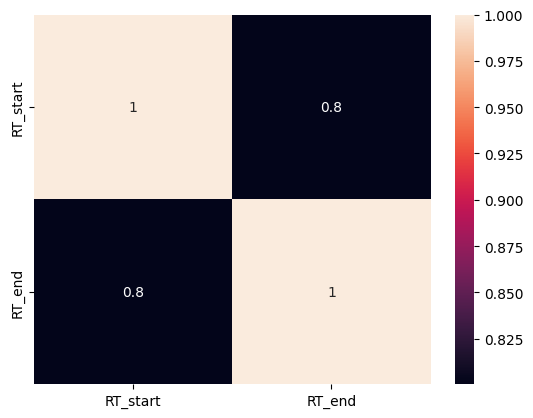

In [ ]:
## Можно еще посмотреть вот так

corr = df_data[["RT_start", "RT_end"]].corr()
sns.heatmap(corr, annot=True)

## Оч сильно скоррелированы